In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from TWA_Design_Tools import TWA_Design_Toolkit
from TWA_skrf_Toolkit import TWA_skrf_Toolkit as rftoolkit
import skrf as rf
from scipy.optimize import minimize

In [2]:
# Enter the physical parameters of the antenna 
num_straps = 9
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.arange(81,112, 1)#  np.array([96, 97]) # MHz
# capfile = 'circ_model/S11_cap_90to102MHz_16cm_capbox_og_width_touse.csv'#'circ_model/S11_cap_81to111MHz.csv'#
capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'#'circ_model/S11_cap_81to111MHz.csv'#
#antfile = 'circ_model/fixed_bigscan_90to102MHz.csv'#'circ_model/fixed_bigscan_90to102MHz.csv' #'circ_model/fixed_Smat_ant_96_and_97_deembed.csv'
antfile = 'circ_model/fixed_bigscan_full.csv' #'circ_model/fixed_Smat_ant_96_and_97_deembed.csv'
myrfTWA = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile)

# add items to geometry
ar = 1.5e-2
d = 15.625e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA.add_to_geometry('ar', ar)
myrfTWA.add_to_geometry('d', d)
myrfTWA.add_to_geometry('s0', s0)
myrfTWA.add_to_geometry('wstrap', wstrap)
myrfTWA.add_to_geometry('l', l)
myrfTWA.add_to_geometry('ts', ts)
myrfTWA.add_to_geometry('tbox', tbox)
myrfTWA.add_to_geometry('h', h)
myrfTWA.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA.add_to_geometry('wcap', wcap)
myrfTWA.add_to_geometry('wcapbox', wcapbox)
myrfTWA.add_to_geometry('tdiv', tdiv)
myrfTWA.add_to_geometry('dcap', dcap)
myrfTWA.add_to_geometry('dcapbox', dcapbox)
myrfTWA.add_to_geometry('lcapbox', lcapbox)
myrfTWA.add_to_geometry('lcut', lcut)
myrfTWA.add_to_geometry('ldeembed', ldeembed)
myrfTWA.add_to_geometry('lfeed', lfeed)

myrfTWA.print_geometry()

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
num_straps:     9
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.15625
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


(0.9839312331746314-0.1785280708913188j)
(1000,)


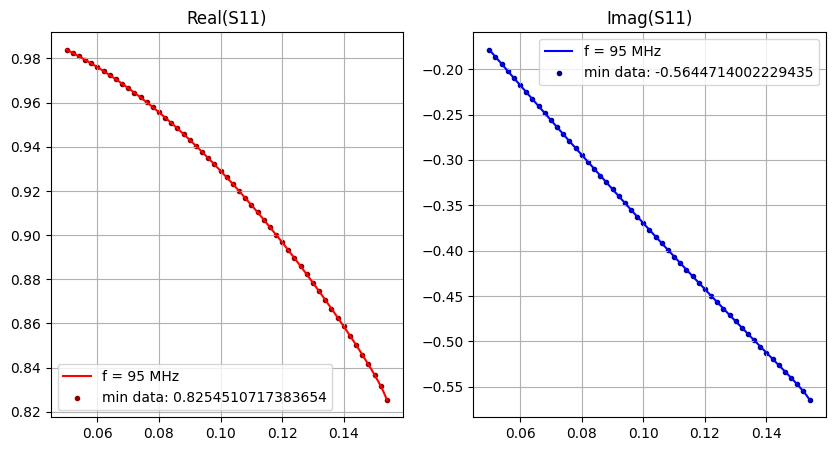

In [3]:
# plot the capacitor
lengths = np.linspace(0.05, 0.154, 1000)
S11_array = np.zeros_like(lengths, dtype='complex')
f = 95

for i in range(lengths.shape[0]):
    l = lengths[i]
    capnet = myrfTWA.build_capnet_given_length_interpolated(length=l, freqs=myrfTWA.freqs_for_fullant)
    i_f = np.where(myrfTWA.freqs_for_fullant == f)
    S11 = capnet.s[i_f][0][0][0]
    S11_array[i] = S11
    if i ==0:
        print(S11)
print(S11_array.shape)
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(lengths, np.real(S11_array), label=f'f = {f} MHz', color='red')
ax[1].plot(lengths, np.imag(S11_array), label=f'f = {f} MHz', color='blue')


ax[0].grid()
ax[1].grid()

ax[0].set_title('Real(S11)')
ax[1].set_title('Imag(S11)')


# raw data 
file_name = 'circ_model/S11_cap_90to102MHz_16cm_capbox_og_width_touse.csv'
length_data = np.arange(0.05, 0.156, 0.002)
S11_found = np.zeros_like(length_data, dtype='complex')
lfound = np.zeros_like(length_data, dtype='complex')
for i in range(length_data.shape[0]):
    ffound, lcapfound, S11, S11db, Z0_port, VSWR = myrfTWA.get_cap_S_given_f_and_lcap(filename=file_name,
                                                                                       f=f, lcap=length_data[i], round_level=3)
    S11_found[i] = S11
    lfound[i] = lcapfound

ax[0].scatter(length_data, np.real(S11_found), marker='.', color='darkred', label=f'min data: {np.min(np.real(S11_found))}')
ax[1].scatter(length_data, np.imag(S11_found), marker='.', color='darkblue', label=f'min data: {np.min(np.imag(S11_found))}')
ax[0].legend()
ax[1].legend()


In [4]:
# Testing out the differential evolution optimization method 
# confirm class version works 

bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92, 100)
s11cutoff = -45

# res = myrfTWA.run_differential_evolution_global_op(bounds,
#                                             S11_db_cutouff=s11cutoff,
#                                             freq_bounds=freq_bounds,
#                                             strategy='best1bin',
#                                             symetric_mode=True,
#                                             one_cap_type_mode=False)

In [5]:
lengths_found = res.x.tolist()
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found, symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].grid()
ax[1,1].grid()

NameError: name 'res' is not defined

NameError: name 'S11_mag_array' is not defined

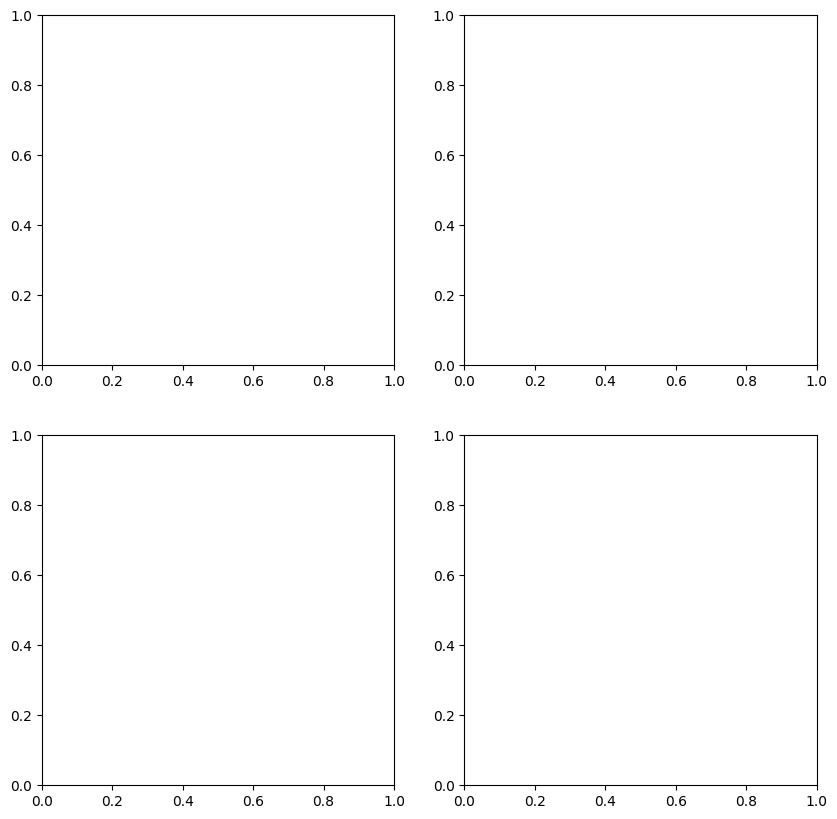

In [6]:
# now plot the solution next to the data
# load up full comsol model's scan 
filename = 'circ_model/fscan_longer_caps_v1.csv'
#filename = 'circ_model/fscan_10_25_fullant.csv'
dataset, headers = myrfTWA.get_comsol_datatable(filename)
fd = dataset[:, 0]
S11d = dataset[:,1]
S21d = dataset[:,2]

S11d_mag = np.abs(S11d)
S21d_mag = np.abs(S21d)

S11d_db = 20*np.log(S11d_mag)
S21d_db = 20*np.log(S21d_mag)


fig, ax = plt.subplots(2,2,figsize=(10,10))

# plot optimization circuit
ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue', label='circuit model')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue', label='circuit model')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red', label='circuit model')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red', label='circuit model')
ax[1,0].grid()
ax[1,1].grid()

# plot data

ax[0,0].plot(fd, S11d_mag, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[0,1].plot(fd, S11d_db, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[1,0].plot(fd, S21d_mag, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[1,1].plot(fd, S21d_db, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[0,0].plot(fd, S11d_mag, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[0,1].plot(fd, S11d_db, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[1,0].plot(fd, S21d_mag, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[1,1].plot(fd, S21d_db, marker='*', color='darkred', label='COMSOL',linestyle='--')

ax[0,0].set_xlabel('f [MHz]')
ax[0,1].set_xlabel('f [MHz]')
ax[1,0].set_xlabel('f [MHz]')
ax[1,1].set_xlabel('f [MHz]')

ax[0,0].set_ylabel('|S11|')
ax[0,1].set_ylabel('S11 [dB]')
ax[1,0].set_ylabel('|S21|')
ax[1,1].set_ylabel('S21 [dB]')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [7]:
# now trying differential evolution with the pure capacitor model 

bounds = [(5.3656e-12, 60e-12)]*5
freq_bounds = (93, 98)
s11cutoff = -35

# res2 = myrfTWA.run_differential_evolution_global_op_explicitC(bounds,
#                                             S11_db_cutouff=s11cutoff,
#                                             freq_bounds=freq_bounds,
#                                             strategy='best1bin',
#                                             symetric_mode=True,
#                                             one_cap_type_mode=False)

In [8]:
Cs_found = res2.x.tolist()
#Cs_found = [42.59722182, 28.77599259, 21.77324347, 29.38619356, 31.11430196]
print('final Cs:', np.array(Cs_found)*1e12, 'pF')
full_net_optimized = myrfTWA.get_fullant_given_Cs_via_caps_from_internal_datatable(Cs_found, symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].grid()
ax[1,1].grid()

NameError: name 'res2' is not defined

In [9]:
# figure out what length corrisponds to what capacitance
# optimize with a capacitor C object instead of lengths and see if they match up 
lmin = 0.05
lmax = 0.154#0.095
fi = 96
capmin = myrfTWA.build_capnet_given_length_from_internal_datatable(length=lmin, freqs=np.array([fi]))
zcapmin, Cmin = myrfTWA.print_znorm_and_capacitance(capmin, fi, toprint=True)
capmax = myrfTWA.build_capnet_given_length_from_internal_datatable(length=lmax, freqs=np.array([fi]))
zcapmax, Cmax = myrfTWA.print_znorm_and_capacitance(capmax, fi, toprint=True)
m = (Cmax - Cmin)*1e12/(lmax - lmin)
b = Cmax*1e12 - m*lmax
print(m)
print(b)

lget = 0.05
print(m*lget + b)

Zcap:(0.0019835242279406477-102.8226046402893j), z0: [9.3506+0.j], Zcap/z0: [0.00021213-10.99636437j]
C = 16.12353622377477 pF
Zcap:(6.605335561681456e-05-29.90435428561749j), z0: [9.3506+0.j], Zcap/z0: [7.0640767e-06-3.19812143j]
C = 55.43888273614812 pF
378.03217800358993
-2.778072676404726
16.12353622377477


In [10]:
# calculating new seperation distance 

n_op = 3.5245#3.1832#1.8079
f = 96e6
w = 2*np.pi*f
clight = 3e8
dold = 0.15625
dphi_new = n_op*(w*dold)/clight
print('dphi_new', dphi_new/np.pi, 'pi')
print(dphi_new*180/np.pi, 'deg')
npar_target = 5
d_new = dphi_new*clight/(npar_target*w)
print('d_new', d_new)

szpp = 10.25e-2
npar_pp = dphi_new*clight/(szpp*w)
kpp = dphi_new/szpp
print(npar_pp)
print(kpp)

dphi_new 0.35245000000000004 pi
63.44100000000001 deg
d_new 0.110140625
5.372713414634147
10.8024812756851


In [12]:
# Testing out the differential evolution optimization method with same caps being enforced 
# confirm class version works 

bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92, 100)
s11cutoff = -45
beta=100#65

# res = myrfTWA.run_differential_evolution_global_op_l_matters(bounds,
#                                             S11_db_cutouff=s11cutoff,
#                                             freq_bounds=freq_bounds,
#                                             beta_length_op=beta,
#                                             strategy='best1bin',
#                                             symetric_mode=True,
#                                             one_cap_type_mode=False)

In [13]:
lengths_found = res.x.tolist()
lsmall = 0.002#-.05e-2
#TODO REMOVE
lengths_found = (np.array(lengths_found) + lsmall).tolist()
##
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found, symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].grid()
ax[1,1].grid()

NameError: name 'res' is not defined

C:\Users\jacob\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


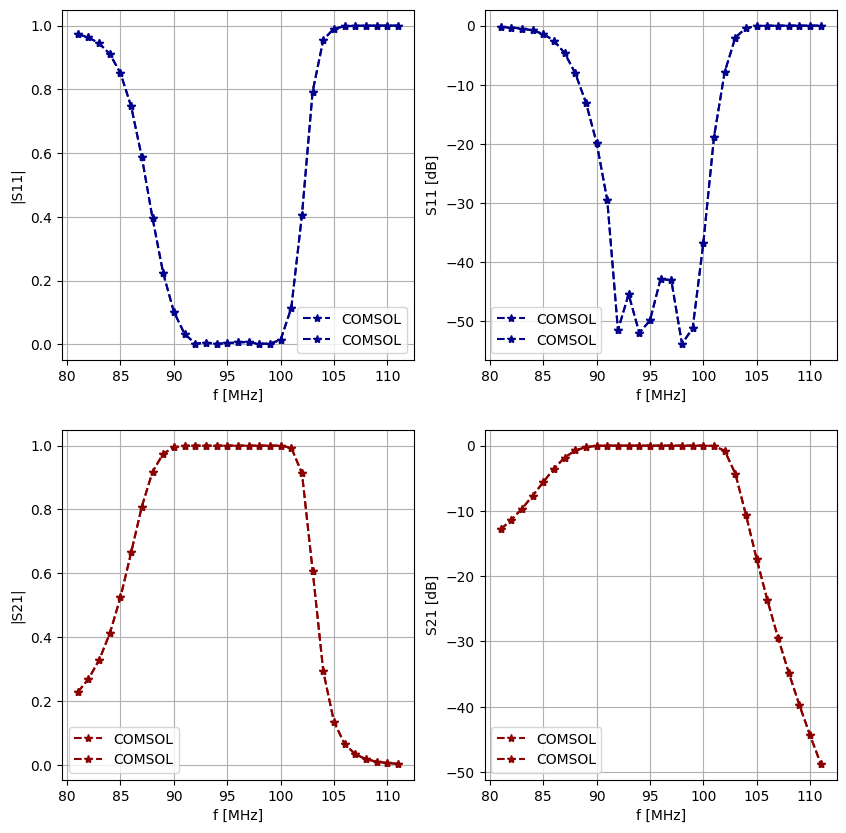

In [14]:
# now plot the solution next to the data
# load up full comsol model's scan 
#filename = 'circ_model/npar5v1.csv'
#filename = 'circ_model/fscan_10_25_fullant.csv'
filename = 'circ_model/fscan_first_npar_op.csv'
dataset, headers = myrfTWA.get_comsol_datatable(filename)
fd = dataset[:, 0]
S11d = dataset[:,1]
S21d = dataset[:,2]

S11d_mag = np.abs(S11d)
S21d_mag = np.abs(S21d)

S11d_db = 20*np.log10(S11d_mag)
S21d_db = 20*np.log10(S21d_mag)


fig, ax = plt.subplots(2,2,figsize=(10,10))

# # plot optimization circuit
# ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue', label='circuit model')
# ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue', label='circuit model')
ax[0,0].grid()
ax[0,1].grid()
# ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red', label='circuit model')
# ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red', label='circuit model')
ax[1,0].grid()
ax[1,1].grid()

# plot data

ax[0,0].plot(fd, S11d_mag, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[0,1].plot(fd, S11d_db, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[1,0].plot(fd, S21d_mag, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[1,1].plot(fd, S21d_db, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[0,0].plot(fd, S11d_mag, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[0,1].plot(fd, S11d_db, marker='*', color='darkblue', label='COMSOL',linestyle='--')
ax[1,0].plot(fd, S21d_mag, marker='*', color='darkred', label='COMSOL',linestyle='--')
ax[1,1].plot(fd, S21d_db, marker='*', color='darkred', label='COMSOL',linestyle='--')

ax[0,0].set_xlabel('f [MHz]')
ax[0,1].set_xlabel('f [MHz]')
ax[1,0].set_xlabel('f [MHz]')
ax[1,1].set_xlabel('f [MHz]')

ax[0,0].set_ylabel('|S11|')
ax[0,1].set_ylabel('S11 [dB]')
ax[1,0].set_ylabel('|S21|')
ax[1,1].set_ylabel('S21 [dB]')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [15]:
# tryting out my new end_cap mode 

bounds = [(0.05, 0.154)]*2
freq_bounds = (90, 102)
s11cutoff = -35

# res = myrfTWA.run_differential_evolution_global_op(bounds,
#                                             S11_db_cutouff=s11cutoff,
#                                             freq_bounds=freq_bounds,
#                                             strategy='best1bin',
#                                             symetric_mode=False,
#                                             one_cap_type_mode=False,
#                                             end_cap_mode=True)

In [16]:
lengths_found = res.x.tolist()
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found, end_cap_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].grid()
ax[1,1].grid()

NameError: name 'res' is not defined

In [17]:
# area to try and get phase differences from the circuit object 
#lengths = [0.12713702242164984, 0.0905852585614057, 0.08731772281347729, 0.12012812640377653, 0.1277804639066831] # these are the good ones that lead to n|| = 5, low reflections
#lengths = [0.11741609800861533, 0.0820165808312631, 0.05841808946546785, 0.09435020209400206, 0.12286721957227252] # these had < -45 dB or reflections in the 92 to 100 band
lengths = [0.1311778221225474, 0.11519046885602385, 0.14010718256369714, 0.12735421956841164, 0.1431832918398686] # these are for the < -45 dB, beta = 100, f = 92 to 100
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths, symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0] # power excitation at the two ports 
phase = [0, 0] # radians 
print('port indicies', full_circ.port_indexes)
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
# print(full_circ.currents(power,phase).shape)
print(full_circ.frequency.f_scaled)
print(full_circ.currents(power,phase)[2,:])
print('--')
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 2,2)[:,1][2:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)



port indicies [1, 3]
[ 81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111.]
[ 0.09196485+0.15484867j -0.09196485-0.15484867j -0.09176057-0.09861208j
  0.09176057+0.09861208j -0.2222944 -0.52026753j  0.2222944 +0.52026753j
 -0.12194338-0.14413168j  0.12194338+0.14413168j  0.12625467+0.43335241j
 -0.12625467-0.43335241j  0.15877399+0.21495884j -0.15877399-0.21495884j
 -0.03817372-0.32577576j  0.03817372+0.32577576j -0.16304979-0.22672365j
  0.16304979+0.22672365j -0.05558113+0.19379096j  0.05558113-0.19379096j
  0.13873437+0.21774855j -0.13873437-0.21774855j  0.17206011+0.00871319j
 -0.17206011-0.00871319j]
--
[ 0.31429585+0.25661112j  0.30089388-0.46451831j -0.56436172-0.0251347j
  0.37009327+0.56928981j  0.19234219-0.58339819j -0.63980068+0.22492525j
  0.4804076 +0.34629676j  0.03000748-0.58722632j -0.42325926+0.01139609j]
[  39.23038606  -57.06666524 -177.44993071   56.97224859  -71

[ 0.21794659 -0.31703703 -0.98583295  0.31651249 -0.39862769  0.89239228
  0.19880862 -0.48374839  0.9914317 ]


Text(0, 0.5, 'P(n||) [arb]')

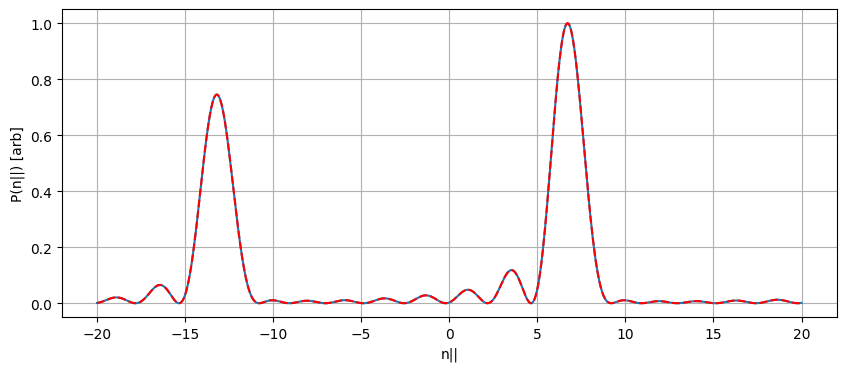

In [18]:
npar_array = np.linspace(-20, 20, 1000)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)))


# try adjusting phases by a constant 

strap_phases2 = strap_phases #+ np.array([40, 60, 20, 25, 3, 45, 180, 8, 12]) * (np.pi/180)
result2 = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases2)
    result2 = np.append(result2, power)

plt.plot(npar_array, np.real(result2)/np.max(np.real(result2)), color='red', linestyle='--')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

[  38.76533735  -57.52564163 -179.03263026   54.55775664  -74.88705166
  156.8699224    31.06947552  -92.07114936  173.17510261]
d:  0.15625
wstrap:  0.08


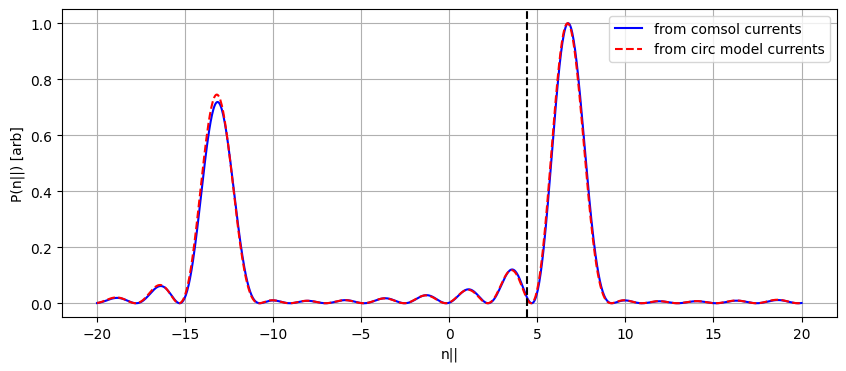

In [19]:
# trying to see what the capacitor phasing is telling me the spectrum should be 

#cap_currents = np.array([0.0063572+0.0064476*1j, 0.0039587-0.0050712*1j, -0.0014627-0.0044506*1j, -0.010477+0.0045642*1j, 0.011497+0.0088503*1j, 0.0013943-0.011558*1j, -0.0045847-2.0756E-4*1j, -0.0036680+0.0052925*1j, 0.0078183+0.0044676*1j])
# these below are the thin sliver, front face. Above is the whole upper plate 
#cap_currents = np.array([7.3908E-4+0.0010242*1j, 8.3484E-4-0.0010754*1j, -3.3213E-4-9.8780E-4*1j, -0.0016580+7.3039E-4*1j, 0.0017127+0.0013188*1j, 2.2902E-4-0.0018320*1j, -0.0010186-5.2867E-5*1j, -7.8029E-4+0.0011173*1j, 0.0011658+4.4391E-4*1j])
# the ones below are the strap fronts: 
#cap_currents = np.array([0.0070595+0.017950*1j, 0.014172-0.017876*1j, -0.0055088-0.016458*1j, -0.027039+0.011972*1j, 0.028014+0.021620*1j, 0.0037355-0.029833*1j, -0.017104-8.7183E-4*1j, -0.013046+0.018918*1j, 0.018829+0.0019756*1j])
#the ones below now are the thin sliver, but this time all the way around the capacitor surface. 
#cap_currents = np.array([0.0030204+0.0024701*1j, 0.0025562-0.0032497*1j, -9.7012E-4-0.0029953*1j, -0.0045309+0.0019607*1j, 0.0046051+0.0035419*1j, 5.8898E-4-0.0050038*1j, -0.0030858-1.2083E-4*1j, -0.0023410+0.0034061*1j, 0.0031598+0.0022853*1j])
# the ones below are for the different lengths for the -45 dB, 0 beta, 92 to 100 case 
#cap_currents = np.array([0.0028237+0.0022259*1j, 0.0029862-0.0022823*1j, 1.8037E-4-0.0021296*1j, -0.0030972-0.0029667*1j, -0.0020828+0.0037516*1j, 0.0041430+0.0010977*1j, 0.0017131-0.0012718*1j, 3.7257E-4-0.0037458*1j, -0.0033664-0.0012549*1j])
# the ones belwo are for the -45 dB, 100 beta, 92 to 100 case
cap_currents = np.array([0.0031801+0.0025537*1j, 0.0029809-0.0046837*1j, -0.0056296-9.5058E-5*1j, 0.0038771+0.0054471*1j, 0.0015648-0.0057942*1j, -0.0060589+0.0025881*1j, 0.0048643+0.0029308*1j, -2.0236E-4-0.0055956*1j, -0.0040003+4.7877E-4*1j])
cap_phases = get_phase(cap_currents)
print(cap_phases*180/np.pi)
print('d: ', myrfTWA.geometry_dict['d'])
print('wstrap: ', myrfTWA.geometry_dict['wstrap'])
npar_array = np.linspace(-20, 20, 1000)

result = np.array([], dtype='complex')
freq = 96e6
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=0.085,
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=cap_phases)
    result = np.append(result, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result)/np.max(np.real(result)), color='blue', label='from comsol currents')
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='from circ model currents')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=4.384384384384383, ymin=0, ymax=1, color='k', linestyle='--')

In [20]:
# phase calculator 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
    

num = 2 - 2*1j
print(get_phase(num)/np.pi, 'pi')

-0.25 pi


In [21]:
# Testing out the new cost funtion which includes the npar maximum 
lengths = [0.1311778221225474, 0.11519046885602385, 0.14010718256369714, 0.12735421956841164, 0.1431832918398686]
returned = myrfTWA.get_peak_npar_spectrum(lengths, npar_bounds=[-20,20], freq=96e6, num_npars=1000, power=[1,0], phase=[0,0],
                                symetric_mode=True,
                                one_cap_type_mode=False,
                                end_cap_mode=False)
print('--')
print(returned)


--
6.706706706706708


In [44]:
# Now, test out the new optimizer 
bounds = [(0.05, 0.154)]*5#[(0.02, 0.095)]*5
freq_bounds = (92, 100)
s11cutoff = -45

# new settings 
alpha = 200000 # 10,000 worked well 
target_npar = 5
npar_bounds = [0, 10]
num_npars = 100


res = myrfTWA.run_differential_evolution_global_op_npar_match( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            target_npar=5,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False)

----------------------------------------
i_iter = 1
New simulation.
Point is: [0.05306039 0.14235162 0.15152741 0.06787975 0.10823509]
Average absolute error is : 1.33e+05
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.07730713 0.12938531 0.09800159 0.11179209 0.15378894]
Average absolute error is : 1.52e+05
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.14456273 0.10919536 0.12590976 0.09948983 0.13347487]
Average absolute error is : 1.79e+04
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.0920186  0.0836696  0.11241495 0.13306814 0.0679758 ]
Average absolute error is : 2.61e+04
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.11054707 0.11113279 0.07455045 0.09592826 0.13213762]
Average absolute error is : 2.41e+04
----------------------------------------
i_iter = 6
New simulation.
Point is: [0.13594849 0.12815664 0.08098692 0.10325532 0.11489743]
Avera

final lengths: [0.12998809396691152, 0.09341376231862622, 0.07767666919003641, 0.11068033579194364, 0.13026046003881644]
5
5


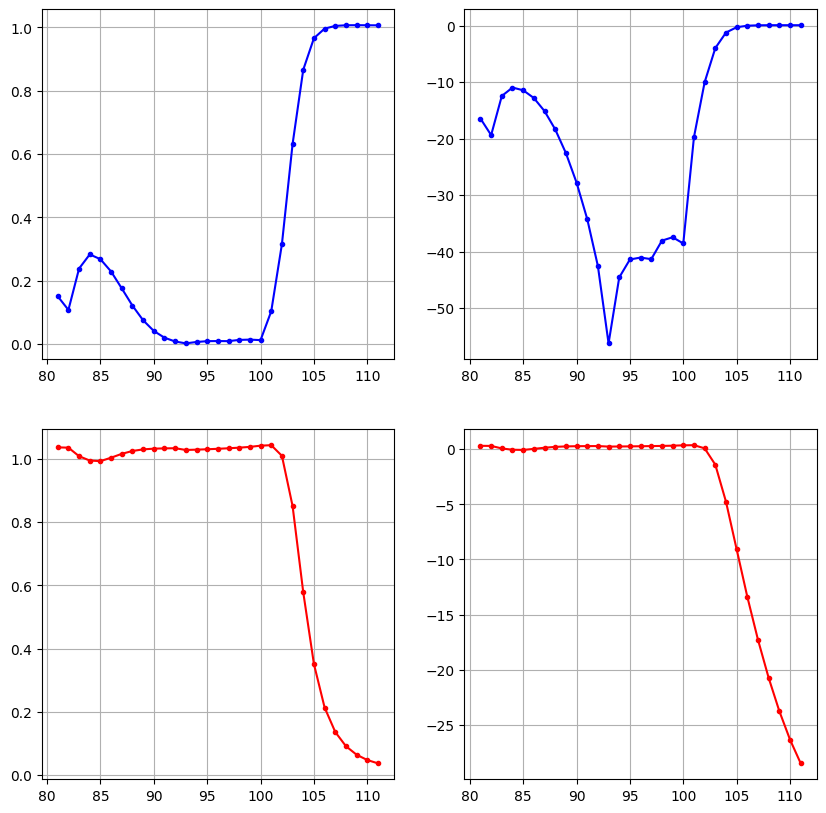

In [45]:
lengths_found = res.x.tolist()
print('final lengths:',lengths_found)
print(len(lengths_found))
print(len(lengths_found))
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].grid()
ax[1,1].grid()
# saved great lengths: [0.12810392247316846, 0.11046490960219796, 0.13937978734857429, 0.10464024587092911, 0.05006480615180657]

In [46]:

full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found, symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0] # power excitation at the two ports 
phase = [0, 0] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 2,2)[:,1][2:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad

strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

port indicies [1, 3]
[ 0.23060139+0.00230436j -0.23060139-0.00230436j  0.05998315+0.26028123j
 -0.05998315-0.26028123j -0.2065567 -0.25238577j  0.2065567 +0.25238577j
 -0.34008205+0.04615922j  0.34008205-0.04615922j -0.24834804+0.18162655j
  0.24834804-0.18162655j -0.23494203+0.42577505j  0.23494203-0.42577505j
  0.193051  +0.17428161j -0.193051  -0.17428161j  0.31764625-0.3538481j
 -0.31764625+0.3538481j   0.10034128-0.31764563j -0.10034128+0.31764563j
 -0.0431954 -0.39248632j  0.0431954 +0.39248632j -0.28120941-0.1783967j
  0.28120941+0.1783967j ]
--
[ 0.31333651+0.24302308j  0.25347963-0.34020091j -0.10634332-0.22840529j
 -0.47659208+0.09039784j  0.34607176+0.431834j    0.19953315-0.44447055j
 -0.20659389-0.15645071j -0.40095483+0.1731732j   0.17753152+0.37051921j]
[  37.79707368  -53.31064587 -114.96623566  169.25997891   51.29131474
  -65.82358129 -142.86385314  156.64038656   64.39893652]


[ 0.20998374 -0.29617025 -0.63870131  0.94033322  0.28495175 -0.36568656
 -0.79368807  0.87022437  0.35777187]


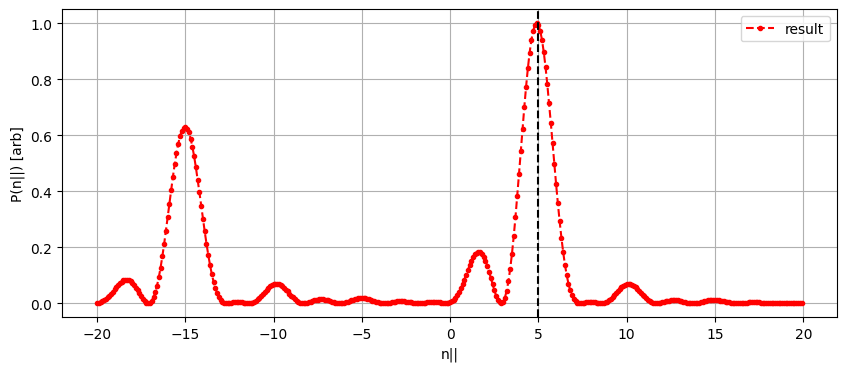

: 

In [48]:
#npar_array = np.arange(0, 10, .1)
npar_array = np.linspace(npar_bounds[0], npar_bounds[1], num_npars)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
freq = 96e6
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')
plt.legend()
plt.axvline(x=5, ymin=0, ymax=1, color='k', linestyle='--')

In [66]:
print(npar_array)

[-1.00000000e+01 -9.90000000e+00 -9.80000000e+00 -9.70000000e+00
 -9.60000000e+00 -9.50000000e+00 -9.40000000e+00 -9.30000000e+00
 -9.20000000e+00 -9.10000000e+00 -9.00000000e+00 -8.90000000e+00
 -8.80000000e+00 -8.70000000e+00 -8.60000000e+00 -8.50000000e+00
 -8.40000000e+00 -8.30000000e+00 -8.20000000e+00 -8.10000000e+00
 -8.00000000e+00 -7.90000000e+00 -7.80000000e+00 -7.70000000e+00
 -7.60000000e+00 -7.50000000e+00 -7.40000000e+00 -7.30000000e+00
 -7.20000000e+00 -7.10000000e+00 -7.00000000e+00 -6.90000000e+00
 -6.80000000e+00 -6.70000000e+00 -6.60000000e+00 -6.50000000e+00
 -6.40000000e+00 -6.30000000e+00 -6.20000000e+00 -6.10000000e+00
 -6.00000000e+00 -5.90000000e+00 -5.80000000e+00 -5.70000000e+00
 -5.60000000e+00 -5.50000000e+00 -5.40000000e+00 -5.30000000e+00
 -5.20000000e+00 -5.10000000e+00 -5.00000000e+00 -4.90000000e+00
 -4.80000000e+00 -4.70000000e+00 -4.60000000e+00 -4.50000000e+00
 -4.40000000e+00 -4.30000000e+00 -4.20000000e+00 -4.10000000e+00
 -4.00000000e+00 -3.90000

In [ ]:
# # checking that this matches greg's thesis 

# # Enter the physical parameters of the antenna 
# num_straps = 9
# f0 = 4.6e9
# w0 = 2*np.pi*f0
# clight = 3e8
# Rant = 1.12 # m, hfs of d3d

# # See code logbook "my antenna" section. This is for shot 147634. 
# n_par = -5 
# k_par = w0*n_par/clight
# print(f'k_par : {k_par} 1/m')
# n_phi = Rant*k_par
# print(f'n_phi: {n_phi}')

# # settings to create the rf toolkit object 
# capz0 = 9.3506
# antz0 = 30
# freqs_for_fullant = np.arange(81,112, 1)#  np.array([96, 97]) # MHz
# # capfile = 'circ_model/S11_cap_90to102MHz_16cm_capbox_og_width_touse.csv'#'circ_model/S11_cap_81to111MHz.csv'#
# capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'#'circ_model/S11_cap_81to111MHz.csv'#
# #antfile = 'circ_model/fixed_bigscan_90to102MHz.csv'#'circ_model/fixed_bigscan_90to102MHz.csv' #'circ_model/fixed_Smat_ant_96_and_97_deembed.csv'
# antfile = 'circ_model/fixed_bigscan_full.csv' #'circ_model/fixed_Smat_ant_96_and_97_deembed.csv'
# myrfTWA2 = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
#                     antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile)

# # add items to geometry
# ar = 1.5e-2
# d = 0.0055 + 0.0015
# s0 = 16e-2
# wstrap = 0.0055
# l = 15e-2
# ts = 0.5e-2
# tbox = 1e-2
# h = .5e-2
# t_cap_extend = 0.25e-2
# wcap = wstrap + 2*t_cap_extend # 1 cm on either side
# wcapbox = wcap + 2*h
# tdiv = myrfTWA2.geometry_dict['s_rez'] - 2*h - wcap 
# dcap = ts + 2*t_cap_extend
# dcapbox = dcap + 2*h
# lcapbox = 10e-2
# lcut = 6e-2
# ldeembed = 5e-2
# lfeed = 10e-2

# myrfTWA2.add_to_geometry('ar', ar)
# myrfTWA2.add_to_geometry('d', d)
# myrfTWA2.add_to_geometry('s0', s0)
# myrfTWA2.add_to_geometry('wstrap', wstrap)
# myrfTWA2.add_to_geometry('l', l)
# myrfTWA2.add_to_geometry('ts', ts)
# myrfTWA2.add_to_geometry('tbox', tbox)
# myrfTWA2.add_to_geometry('h', h)
# myrfTWA2.add_to_geometry('t_cap_extended', t_cap_extend)
# myrfTWA2.add_to_geometry('wcap', wcap)
# myrfTWA2.add_to_geometry('wcapbox', wcapbox)
# myrfTWA2.add_to_geometry('tdiv', tdiv)
# myrfTWA2.add_to_geometry('dcap', dcap)
# myrfTWA2.add_to_geometry('dcapbox', dcapbox)
# myrfTWA2.add_to_geometry('lcapbox', lcapbox)
# myrfTWA2.add_to_geometry('lcut', lcut)
# myrfTWA2.add_to_geometry('ldeembed', ldeembed)
# myrfTWA2.add_to_geometry('lfeed', lfeed)

# myrfTWA2.print_geometry()

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
sum1:  (-0.33827190809291463-1.262778200811073j)
sum2:  (-0.33827190809291463+1.262778200811073j)
sum1*sum2:  (1.7090366682484721+0j)
term1:  0.0022177838943790453
sum1:  (-0.37963664065897806-1.1359487266099062j)
sum2:  (-0.37963664065897806+1.1359487266099062j)
sum1*sum2:  (1.4345034884175014+0j)
term1:  0.002271126036818863
sum1:  (-0.40584071605858396-1.0063496721074692j)
sum2:  (-0.40584071605858396+1.0063496721074692j)
sum1*sum2:  (1.1774463493617549+0j)
term1:  0.0023251905962964644
sum1:  (-0.41678833547082994-0.8759099017769212j)
sum2:  (-0.41678833547082994+0.8759099017769212j)
sum1*sum2:  (0.9409306726154009+0j)
term1:  0.002379979930369143
sum1:  (-0.4126237220741692-0.7465357389627615j)
sum2:  (-0.4126237220741692+0.7465357389627615j)
sum1*sum2:  (0.7275739455670176+0j)
term1:  0.0024354963646296183
sum1:  (-0.3937242004587255-0.6200820812806115j)
sum2:  (-0.3937242004587255+0.6200820812806115j)
sum1*sum2:  (0.5395205335521576+0j)
term1:  0.

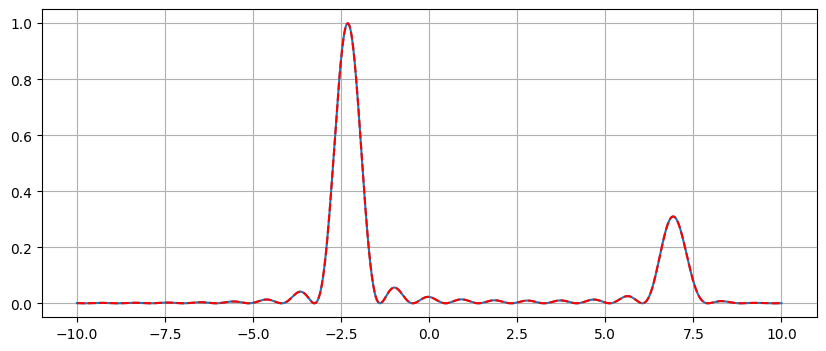

In [ ]:
# npar_array = np.linspace(-10, 10, 1000)
# phase_array = np.arange(0, 10*np.pi/2, np.pi/2)

# print(phase_array/(np.pi/2))

# result = np.array([], dtype='complex')
# freq = 4.6e9
# for i in range(npar_array.shape[0]):
#     power = myrfTWA2.analytic_power_spectrum_general_phase_diff(npar_array[i], strap_width_key='wstrap',
#                                                                 strap_sep_key='d',
#                                                                 freq=freq,
#                                                                 phase_array=phase_array)
#     result = np.append(result, power)

# peak = myrfTWA2.clight*np.pi/2 / (2*np.pi*freq*(myrfTWA2.geometry_dict['d']))
# print('peak n|||: ', peak)
# plt.figure(figsize=(10,4))
# plt.grid()
# plt.plot(npar_array, np.real(result)/np.max(np.real(result)))

# phase_array = np.arange(0, 10*np.pi/2, np.pi/2)
# phase_array[1] = -3*np.pi/2
# print(phase_array/(np.pi/2))

# result = np.array([], dtype='complex')
# freq = 4.6e9
# for i in range(npar_array.shape[0]):
#     power = myrfTWA2.analytic_power_spectrum_general_phase_diff(npar_array[i], strap_width_key='wstrap',
#                                                                 strap_sep_key='d',
#                                                                 freq=freq,
#                                                                 phase_array=phase_array)
#     result = np.append(result, power)

# peak = myrfTWA2.clight*np.pi/2 / (2*np.pi*freq*(myrfTWA2.geometry_dict['d']))
# plt.plot(npar_array, np.real(result)/np.max(np.real(result)), color='red', linestyle='--')